<a href="https://colab.research.google.com/github/sarcasticvibes/Neural-Style-Transfer/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

In [4]:
torch.cuda.get_device_name()

'Tesla T4'

In [6]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        # The first number x in convx_y gets added by 1 after it has gone
        # through a maxpool, and the second y if we have several conv layers
        # in between a max pool. These strings (0, 5, 10, ..) then correspond
        # to conv1_1, conv2_1, conv3_1, conv4_1, conv5_1 mentioned in NST paper
        self.chosen_features = ["0", "5", "10", "19", "28"]

        # We don't need to run anything further than conv5_1 (the 28th module in vgg)
        # Since remember, we dont actually care about the output of VGG: the only thing
        # that is modified is the generated image (i.e, the input).
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        # Store relevant features
        features = []

        # Go through each layer in model, if the layer is in the chosen_features,
        # store it in features. At the end we'll just return all the activations
        # for the specific layers we have in chosen_features
        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features

In [9]:
def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512

# Here we may want to use the Normalization constants used in the original
# VGG network (to get similar values net was originally trained on), but
# I found it didn't matter too much so I didn't end of using it. If you
# use it make sure to normalize back so the images don't look weird.
loader = transforms.Compose(
    [
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

original_img = load_image("/content/1200px-Robert_Downey_Jr_2014_Comic_Con_(cropped).jpg")
style_img = load_image("/content/dancer-500x500.jpg")

# initialized generated as white noise or clone of original image.
# Clone seemed to work better for me.

# generated = torch.randn(original_img.data.shape, device=device, requires_grad=True)
generated = original_img.clone().requires_grad_(True)
model = VGG().to(device).eval()

# Hyperparameters
total_steps = 6000
learning_rate = 0.001
alpha = 0.985
beta = 0.015
optimizer = optim.Adam([generated], lr=learning_rate)

for step in range(total_steps):
    # Obtain the convolution features in specifically chosen layers
    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)

    # Loss is 0 initially
    style_loss = original_loss = 0

    # iterate through all the features for the chosen layers
    for gen_feature, orig_feature, style_feature in zip(generated_features, 
                                                        original_img_features, 
                                                        style_features):

        # batch_size will just be 1
        batch_size, channel, height, width = gen_feature.shape
        original_loss += torch.mean((gen_feature - orig_feature) ** 2)
        # Compute Gram Matrix of generated
        G = gen_feature.view(channel, height * width).mm(
            gen_feature.view(channel, height * width).t()
        )
        # Compute Gram Matrix of Style
        A = style_feature.view(channel, height * width).mm(
            style_feature.view(channel, height * width).t()
        )
        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha * original_loss + beta * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 200 == 0:
        print(total_loss)
        save_image(generated, "generated.png")
save_image(generated, "generated.png")

tensor(392735.5625, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15817.3594, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7784.0444, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5786.2715, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4555.6646, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3662.4685, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2981.8262, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2456.4958, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2047.4572, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1727.4901, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1477.8657, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1274.9379, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1116.3263, device='cuda:0', grad_fn=<AddBackward0>)
tensor(990.9908, device='cuda:0', grad_fn=<AddBackward0>)
tensor(885.2028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(821.5486, device='cuda:0', grad_fn=<AddBackward0>)
tensor(735.0854, device='cuda:0', grad_fn=<AddBackward0>

Original Image:


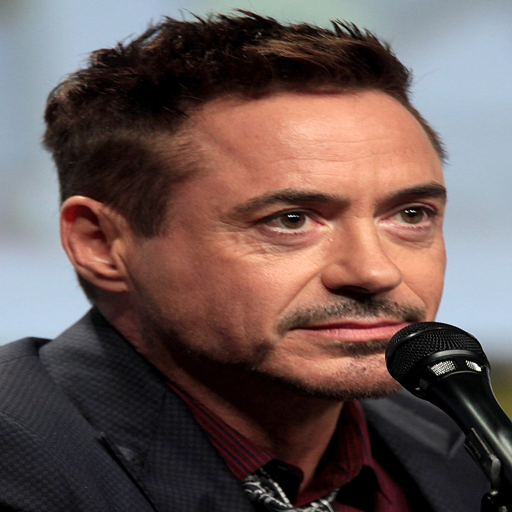

In [16]:
print('Original Image:')
Image.open('/content/1200px-Robert_Downey_Jr_2014_Comic_Con_(cropped).jpg').resize((512,512))

Style Image:


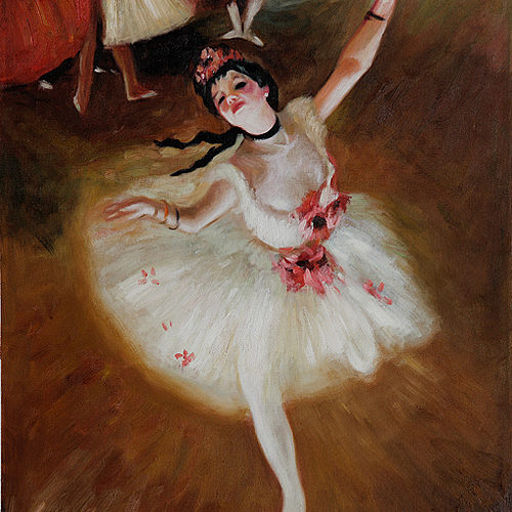

In [17]:
print('Style Image:')
Image.open('/content/dancer-500x500.jpg').resize((512,512))

Style Transfered Image:


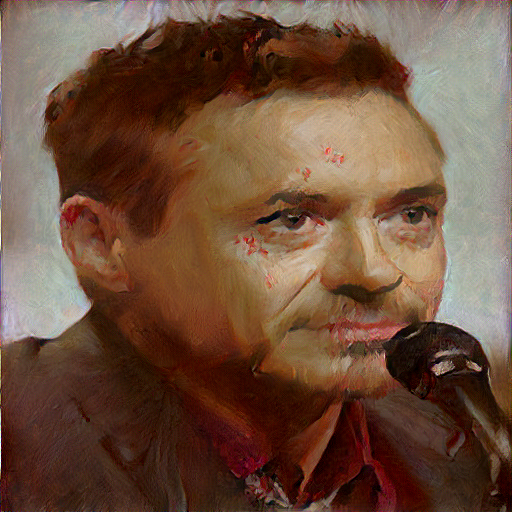

In [13]:
print('Style Transfered Image:')
Image.open('generated.png')